In [49]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt

In [50]:
filtered_dataset = pd.read_csv('filtered_dataset.csv')
filtered_dataset.head()

,ID,Wave,Gender,Age,DeathAge,IncomeGroup,Curr_HealthState,Prev_HealthState
0,1,1,1.male,54,57.0,2.0,1,1
1,1,2,1.male,56,57.0,2.0,1,1
2,1,3,1.male,57,57.0,NaN,0,1
3,2,1,2.female,57,67.0,2.0,1,1
4,2,2,2.female,59,67.0,2.0,1,1


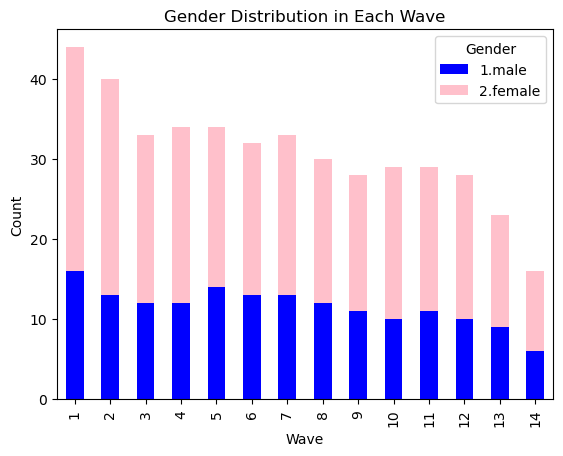

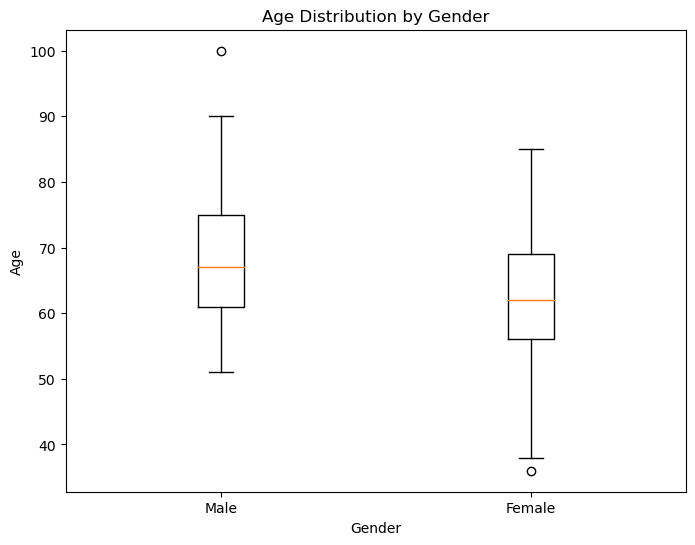

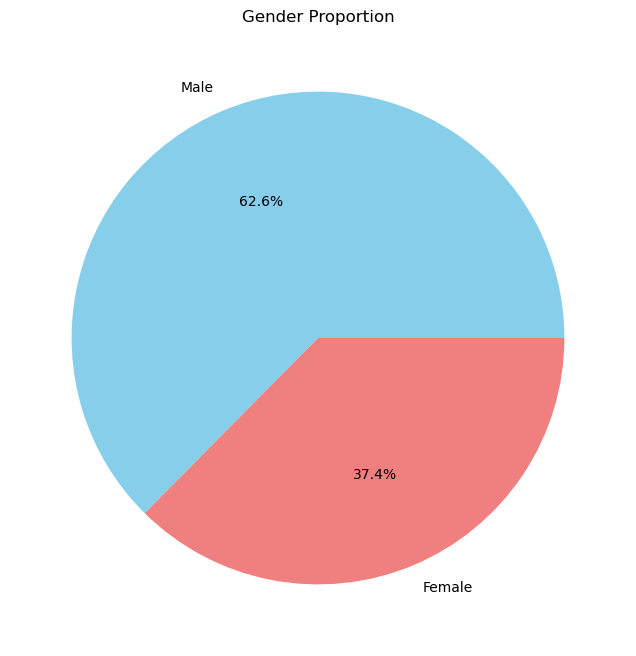

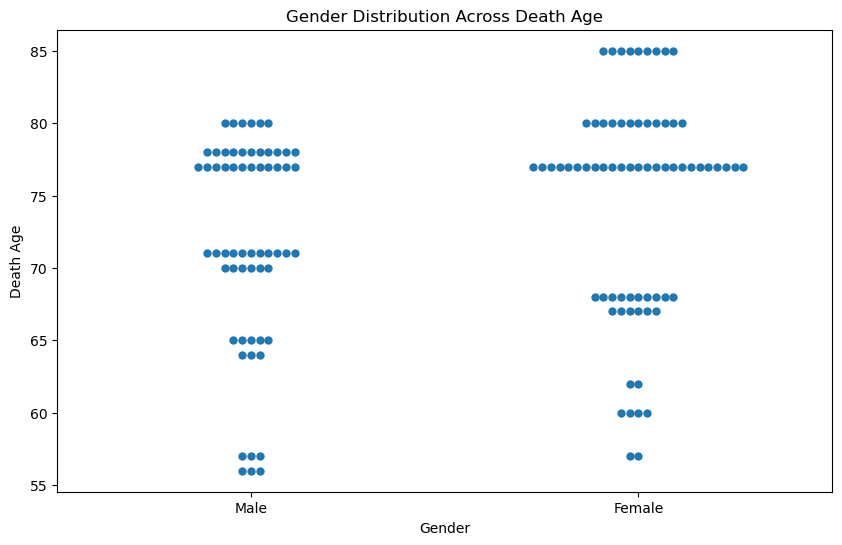

In [57]:
#Visualization
# 2. Gender Distribution in Each Wave (Bar Chart)
gender_distribution = filtered_dataset.groupby(['Wave', 'Gender']).size().unstack()
gender_distribution.plot(kind='bar', stacked=True, color=['blue', 'pink'])
plt.title('Gender Distribution in Each Wave')
plt.xlabel('Wave')
plt.ylabel('Count')
plt.legend(title='Gender', loc='upper right')
plt.show()

# 3. Age Distribution by Gender (Box Plot)
plt.figure(figsize=(8, 6))
plt.boxplot([filtered_dataset[filtered_dataset['Gender'] == '1.male']['Age'], filtered_dataset[filtered_dataset['Gender'] == '2.female']['Age']],
            labels=['Male', 'Female'])
plt.title('Age Distribution by Gender')
plt.xlabel('Gender')
plt.ylabel('Age')
plt.show()

# Calculate gender proportions
gender_counts = filtered_dataset['Gender'].value_counts()
labels = ['Male', 'Female']

# Pie Chart for Gender Proportion
plt.figure(figsize=(8, 8))
plt.pie(gender_counts, labels=labels, autopct='%1.1f%%', colors=['skyblue', 'lightcoral'])
plt.title('Gender Proportion')
plt.show()

# Swarm Plot for Gender Distribution Across Death Age
plt.figure(figsize=(10, 6))
sns.swarmplot(x='Gender', y='DeathAge', data=filtered_dataset, palette='Set1',size=6)
plt.title('Gender Distribution Across Death Age')
plt.xlabel('Gender')
plt.ylabel('Death Age')
plt.xticks(ticks=[0, 1], labels=['Male', 'Female'])
plt.show()

In [21]:
# Convert categorical variables to numeric codes
filtered_dataset['Gender'] = filtered_dataset['Gender'].astype('category').cat.codes
filtered_dataset['Curr_HealthState'] = filtered_dataset['Curr_HealthState'].astype('category').cat.codes
filtered_dataset['Prev_HealthState'] = filtered_dataset['Prev_HealthState'].astype('category').cat.codes

# Impute NaN values in the dataset
imputer = SimpleImputer(strategy='mean')
filtered_dataset_imputed = pd.DataFrame(imputer.fit_transform(filtered_dataset), columns=filtered_dataset.columns)

# Split the dataset into training and testing subsets
np.random.seed(123)
train_indices = np.random.choice(filtered_dataset_imputed.index, int(0.7 * len(filtered_dataset_imputed)), replace=False)
train_data = filtered_dataset_imputed.loc[train_indices]
test_data = filtered_dataset_imputed.drop(train_indices)

# Fit the multinomial logistic regression model
feature_cols = ['Age', 'Gender', 'IncomeGroup', 'Prev_HealthState']
X_train = train_data[feature_cols]
y_train = train_data['Curr_HealthState']
model = LogisticRegression(multi_class='multinomial', solver='newton-cg')
model.fit(X_train, y_train)

# Create a sequence of ages from 65 to 100
ages = np.arange(65, 101)

# Function to calculate transition probabilities for each state at different ages
def calculate_transition_probabilities(ages, model, state_from):
    probabilities = pd.DataFrame({'Age': ages})
    
    for state_to in range(5):  # 0: Dead, 1: Healthy, 2: HHC, 3: NH, 4: HC and NH
        prob_vector = model.predict_proba(pd.DataFrame({
            'Age': ages,
            'Gender': np.full_like(ages, 0, dtype=int),  # Example: Male
            'IncomeGroup': np.full_like(ages, 1, dtype=int),  # Example: IncomeGroup 1
            'Prev_HealthState': np.full_like(ages, state_from, dtype=int)
        }))
        prob_col_name = "Dead" if state_to == 0 else f"State_to_{state_to}"
        probabilities[prob_col_name] = prob_vector[:, state_to]
    
    return probabilities

# Calculate the transition probabilities for each state at different ages
prob_healthy_to_states = calculate_transition_probabilities(ages, model, state_from=1)  # Healthy to other states
prob_hhc_to_states = calculate_transition_probabilities(ages, model, state_from = 2)  # HHC to other states
prob_nh_to_states = calculate_transition_probabilities(ages, model, state_from = 3)   # NH to other states
prob_hc_nh_to_states = calculate_transition_probabilities(ages, model, state_from = 4)  # HC and NH to other states


# Combine the probabilities into one dataframe
transition_probabilities = pd.concat([
    prob_healthy_to_states,
    prob_hhc_to_states.drop(columns=['Age']),
    prob_nh_to_states.drop(columns=['Age']),
    prob_hc_nh_to_states.drop(columns=['Age'])
], axis=1)

# Rename columns as per the specified structure
transition_probabilities.columns = [
    "Age", "Healthy_to_Healthy", "Healthy_to_HHC", "Healthy_to_NH", "Healthy_to_HC_and_NH", "Healthy_to_Dead",
    "HHC_to_Healthy", "HHC_to_HHC", "HHC_to_NH", "HHC_to_HC_and_NH", "HHC_to_Dead",
    "NH_to_Healthy", "NH_to_HHC", "NH_to_NH", "NH_to_HC_and_NH", "NH_to_Dead",
    "HC_and_NH_to_Healthy", "HC_and_NH_to_HHC", "HC_and_NH_to_NH", "HC_and_NH_to_HC_and_NH", "HC_and_NH_to_Dead"
]

transition_probabilities.head()




,Age,Healthy_to_Healthy,Healthy_to_HHC,Healthy_to_NH,Healthy_to_HC_and_NH,Healthy_to_Dead,HHC_to_Healthy,HHC_to_HHC,HHC_to_NH,HHC_to_HC_and_NH,...,NH_to_Healthy,NH_to_HHC,NH_to_NH,NH_to_HC_and_NH,NH_to_Dead,HC_and_NH_to_Healthy,HC_and_NH_to_HHC,HC_and_NH_to_NH,HC_and_NH_to_HC_and_NH,HC_and_NH_to_Dead
0,65,0.028631,0.918799,0.044624,0.005278,0.002668,0.139303,0.582926,0.246600,0.018536,...,0.267333,0.145875,0.537516,0.025678,0.023598,0.284890,0.020271,0.650612,0.019753,0.024474
1,66,0.030253,0.914598,0.046006,0.005920,0.003222,0.144628,0.570145,0.249807,0.020430,...,0.271836,0.139738,0.533290,0.027719,0.027418,0.288430,0.019334,0.642693,0.021231,0.028312
2,67,0.031956,0.910102,0.047415,0.006639,0.003889,0.149984,0.557000,0.252762,0.022492,...,0.276098,0.133705,0.528490,0.029888,0.031820,0.291754,0.018424,0.634301,0.022798,0.032723
3,68,0.033742,0.905277,0.048848,0.007441,0.004691,0.155343,0.543475,0.255432,0.024730,...,0.280077,0.127774,0.523080,0.032186,0.036883,0.294822,0.017539,0.625398,0.024457,0.037784
4,69,0.035612,0.900090,0.050302,0.008337,0.005658,0.160673,0.529553,0.257777,0.027154,...,0.283729,0.121940,0.517024,0.034614,0.042693,0.297595,0.016678,0.615940,0.026208,0.043580


In [30]:
from sklearn.metrics import confusion_matrix

# Convert categorical variables to numeric codes
test_data['Gender'] = test_data['Gender'].astype('category').cat.codes
test_data['Curr_HealthState'] = test_data['Curr_HealthState'].astype('category').cat.codes
test_data['Prev_HealthState'] = test_data['Prev_HealthState'].astype('category').cat.codes

# Extract features and target variable for the test set
X_test = test_data[feature_cols]
y_test = test_data['Curr_HealthState']
# Predict the class labels
y_pred = model.predict(X_test)

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

log_likelihood = model.score(X_test, y_test)
print("Log-Likelihood:", log_likelihood)

Confusion Matrix:
[[ 0  0  7  0  0]
 [16  0 88  0  0]
 [ 0  0 15  0  0]
 [ 0  0  1  0  0]
 [ 0  0  3  0  0]]
Log-Likelihood: 0.11538461538461539


In [31]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score

# Assuming y_train contains the actual labels of your training data
# Identify the majority class
majority_class = y_train.value_counts().idxmax()

# Create a dummy classifier that always predicts the majority class
dummy_classifier = DummyClassifier(strategy='most_frequent')
dummy_classifier.fit(X_train, y_train)

# Make predictions using the dummy classifier
y_pred_baseline = dummy_classifier.predict(X_test)

# Calculate baseline accuracy
baseline_accuracy = accuracy_score(y_test, y_pred_baseline)

print("Baseline Accuracy:", baseline_accuracy)


Baseline Accuracy: 0.8
